<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
np.random.seed(36)

In [3]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()
  
    def refresh(self):
        raise Exception("undefined")

In [4]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

In [5]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$) 

In [6]:
g1 = G1()

Examples:

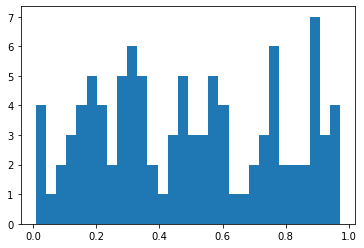

In [7]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

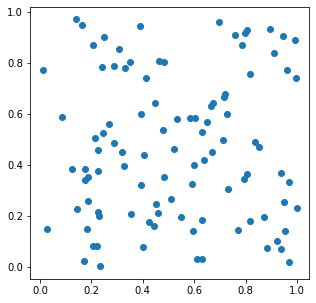

In [8]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [9]:
g1.refresh() # generate a new dataset

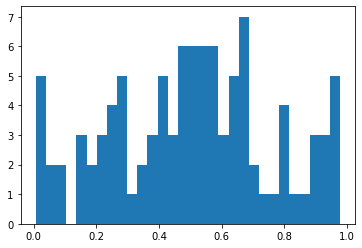

In [10]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [11]:
m = np.array([0., 0.])

for _ in range(10):
    g1.refresh() # refresh the dataset
    m  += 0.1*g1.x.mean()

print(m)

[0.50442458 0.50442458]


### Test on log-normal distribution

In [12]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

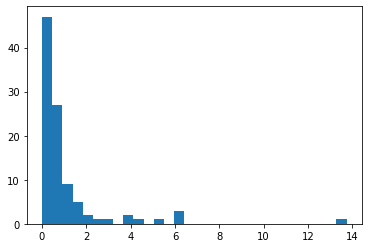

In [13]:
plt.hist(g2.v, bins=30)
plt.show()

In [14]:
g2.refresh() # to generate a new x and v

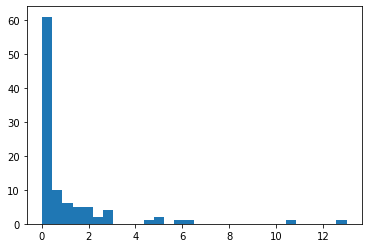

In [15]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [16]:
# fill-in this section with your code

In [17]:
def max_squared_dist(points):
    p1 = np.repeat(points, len(points), axis = 0).reshape((len(points), len(points), 2), order = "F")
    p2 = np.repeat(points, len(points), axis = 0).reshape((len(points), len(points), 2), order = "C")
    return np.max(np.sum(np.square(p1 - p2), axis = 2))

def f(_lambda, x, v):
    return np.sum(v) - _lambda * len(v) * np.pi * max_squared_dist(x) / 4

In [18]:
%%time
#SpeedTest
n1 = 11
n2 = 11
row, col = np.indices((n1, n2))
points = np.dstack([row, col]).flatten().reshape(n1 * n2, 2)
print(max_squared_dist(points))

200
Wall time: 1.99 ms


In [19]:
def Metropolis_Hasting_step(selection, scores, data, remove_duplicates = True):
    ind = np.random.randint(0,data.N, len(selection))
    for i in range(len(selection)):
        mask = np.zeros(data.N, dtype = "bool")
        mask[ind[i]] = True
        proposal = selection[i] ^ mask
        if (np.sum(proposal) > 0):
            old_score = scores[i]
            score = f(_lambda, data.x[proposal], data.v[proposal])
            if score > old_score :
                scores[i] = score
                selection[i] = proposal
    if remove_duplicates:
        selection, ids = np.unique(selection, return_index = True, axis = 0)
        scores = scores[ids]
    return selection, scores

In [20]:
def could_accept_a_move(selection_line, score, data):
    mask = np.zeros(data.N, dtype = "bool")
    for i in range(data.N):
        mask[i] = True
        proposal = selection_line ^ mask
        if (np.sum(proposal) > 0):
            new_score = f(_lambda, data.x[proposal], data.v[proposal])
            if new_score > score :
                return True
        mask[i] = False

In [21]:
def filter_selection(selection, scores, data):
    useless_lines = []
    best_score = np.max(scores)
    for i in range(len(selection)):
        is_best = (scores[i] == best_score)
        if not (could_accept_a_move(selection[i], scores[i], data) or is_best):
            useless_lines.append(i)
    selection = np.delete(selection, useless_lines, axis = 0)
    scores = np.delete(scores, useless_lines, axis = 0)
    return selection, scores

In [22]:
_lambda = 1

In [23]:
g = g1

In [24]:

#selection = np.array([np.zeros(g.N, dtype = "bool")])
#scores = np.zeros(1)

In [25]:
def Metropolis_Hasting(data, plot = False, verbose = False):
    selection = np.identity(data.N, dtype = "bool")
    scores = np.array([f(_lambda, data.x[selection[i]], data.v[selection[i]]) for i in range(len(selection))])
    i = 0
    best_scores = []
    #for j in range(600):
    #while could_accept_a_move(selection[0], scores[0], data):
    while(len(scores) > 1):
        selection, scores = Metropolis_Hasting_step(selection, scores, data, remove_duplicates = True)
        best_scores.append(np.max(scores))
        i += 1
        if i % 100 == 0:
            selection, scores = filter_selection(selection, scores, data)
    selection, scores = filter_selection(selection, scores, data)
    if (verbose):
        print("Score : {}".format(np.max(scores)))
        print("Number of cities : {}".format(np.sum(selection[np.argmax(scores)])))
        print("Batch size : {}".format(len(scores)))
        print("Number of iterations = {}".format(i))
    if (plot):
        plt.figure(figsize=(7,7))
        plt.plot(np.arange(i), best_scores, "g")
        plt.show()
    return selection[0], np.max(scores), 

Score : 10.0179467087628
Number of cities : 23
Batch size : 1
Number of iterations = 1100


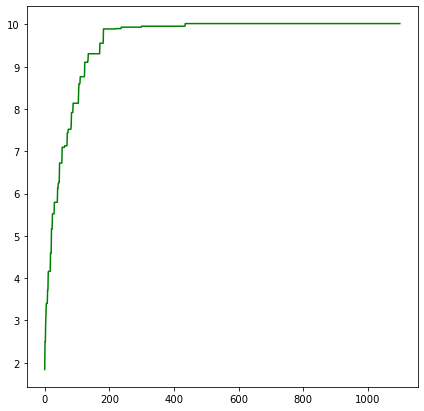

In [26]:
_, _ = Metropolis_Hasting(g, plot = True, verbose = True)

In [97]:
%%time
test_scores = []
for i in range(100):
    sel, score = Metropolis_Hasting(g, plot = False, verbose = False)
    test_scores.append(score)
print(np.min(test_scores))
print(np.max(test_scores))

9.955437186111611
10.0179467087628
Wall time: 8min 12s


In [104]:
test_scores = np.array(test_scores)
np.count_nonzero(test_scores < 10.017)

5

In [55]:
#may change due to randomness of g1
#best : 10.0179467087628 with g1 lambda 1 
#best : 65.73652884950121 with g2 lambda 1